In [1]:
!pip install yfinance -q

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense


Download stock data helper

In [2]:
def download_stock_data(ticker, start="2015-01-01"):
    """
    Download daily prices for a ticker from Yahoo Finance.
    Returns a DataFrame with a single column 'price'.
    Uses 'Adj Close' if available, otherwise 'Close'.
    """
    data = yf.download(ticker, start=start)

    # Pick a suitable price column
    if "Adj Close" in data.columns:
        price_col = "Adj Close"
    elif "Close" in data.columns:
        price_col = "Close"
    else:
        # Fallback: first numeric column
        price_col = data.select_dtypes(include="number").columns[0]

    data = data[[price_col]].copy()
    data.rename(columns={price_col: "price"}, inplace=True)
    data.dropna(inplace=True)

    return data


GRU training function

In [3]:
def train_gru(series,
              window_size=60,
              train_ratio=0.8,
              epochs=20,
              batch_size=32):
    """
    Train a GRU model on a univariate price series.

    series: pandas Series of prices
    window_size: number of past days used to predict next day
    train_ratio: fraction of data for training (rest for test)
    epochs, batch_size: training hyperparameters

    Returns:
      model        - trained Keras model
      scaler       - fitted MinMaxScaler
      y_test_inv   - actual prices in test set
      y_pred_inv   - predicted prices (same length as y_test_inv)
      metrics      - dict with RMSE and MAE
      history      - Keras History object
    """

    # 1. Scale data
    values = series.values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_values = scaler.fit_transform(values)

    # 2. Train / test split
    n = len(scaled_values)
    train_size = int(n * train_ratio)
    train_data = scaled_values[:train_size]
    test_data = scaled_values[train_size - window_size:]  # overlap

    # 3. Turn into sequences
    def create_sequences(data, window):
        X, y = [], []
        for i in range(window, len(data)):
            X.append(data[i - window:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    X_train, y_train = create_sequences(train_data, window_size)
    X_test, y_test   = create_sequences(test_data,  window_size)

    # 4. Reshape for GRU: (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1],  1))

    # 5. Build GRU model
    model = Sequential([
        GRU(64, return_sequences=False, input_shape=(window_size, 1)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # 6. Train
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,
        verbose=1
    )

    # 7. Predict (scaled)
    y_pred_scaled = model.predict(X_test)

    # 8. Inverse transform back to original price scale
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler.inverse_transform(y_pred_scaled).flatten()

    # 9. Metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae  = mean_absolute_error(y_test_inv, y_pred_inv)
    metrics = {"RMSE": rmse, "MAE": mae}

    return model, scaler, y_test_inv, y_pred_inv, metrics, history


Helper to train & evaluate any ticker

In [4]:
def evaluate_gru_for_ticker(ticker,
                            start="2015-01-01",
                            window_size=60,
                            train_ratio=0.8,
                            epochs=20,
                            batch_size=32):
    """
    Download data for a ticker, train GRU, print metrics and show plots.
    """
    print(f"Downloading data for {ticker}...")
    df = download_stock_data(ticker, start=start)
    print(df.head())

    print("\nTraining GRU model...")
    model, scaler, y_test, y_pred, metrics, history = train_gru(
        df["price"],
        window_size=window_size,
        train_ratio=train_ratio,
        epochs=epochs,
        batch_size=batch_size
    )

    print("\nGRU Metrics:", metrics)

    # Plot training & validation loss
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"{ticker} – GRU Training History")
    plt.legend()
    plt.show()

    # Plot actual vs predicted (test period)
    plt.figure(figsize=(12,6))
    plt.plot(y_test, label="Actual")
    plt.plot(y_pred, label="GRU Prediction")
    plt.xlabel("Time Step (test period)")
    plt.ylabel("Price (USD)")
    plt.title(f"{ticker} – GRU Prediction vs Actual (Test)")
    plt.legend()
    plt.show()

    return model, scaler, y_test, y_pred, metrics, history


Run it on AAPL

/tmp/ipython-input-1861724130.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Price           price
Ticker           AAPL
Date                 
2015-01-02  24.237553
2015-01-05  23.554741
2015-01-06  23.556957
2015-01-07  23.887272
2015-01-08  24.805084

Training GRU model...
Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0314 - val_loss: 2.3876e-04
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 1.3644e-04 - val_loss: 2.2092e-04
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 1.0550e-04 - val_loss: 2.0861e-04
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 1.0614e-04 - val_loss: 1.9349e-04
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 9.7755e-05 - val_loss: 1.7967e-04
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 8.1911e-05 - val_loss: 2.7459e-04
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 1.0371e-04 - val_loss: 1.6414e-04
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 8.2851e-05 - val_loss: 1.5822e-04
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 8.

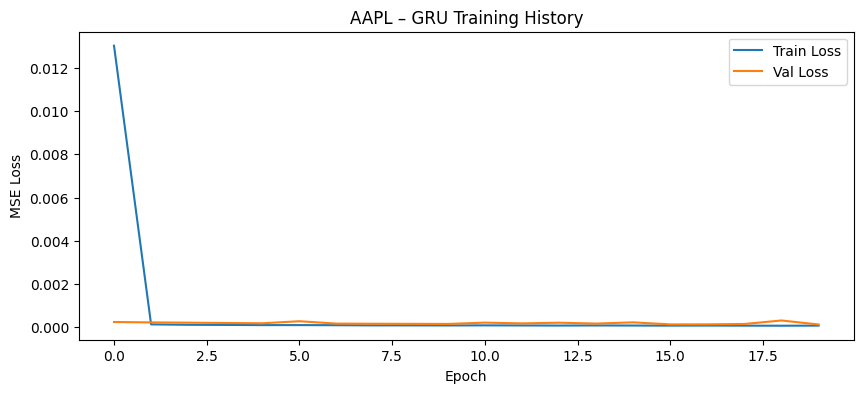

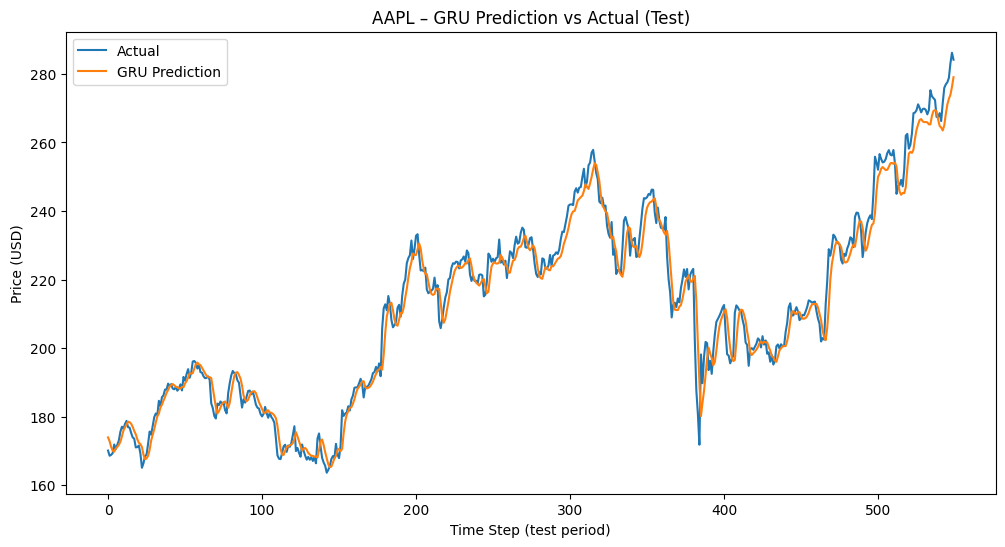

{'RMSE': np.float64(4.753986954452837), 'MAE': 3.4690154196999288}

In [5]:
# Example: evaluate GRU on AAPL
model_gru, scaler_gru, y_test_gru, y_pred_gru, gru_metrics, gru_history = evaluate_gru_for_ticker(
    "AAPL",
    start="2015-01-01",
    window_size=60,
    train_ratio=0.8,
    epochs=20,
    batch_size=32
)

gru_metrics
